Все новое - это хорошо забытое старое

In [1]:
import os
# Ensure TF specific env vars are set before TF import
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # Filter out INFO and WARNING logs

import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tqdm import tqdm # tqdm can be uncommented if progress bar is needed
import traceback
from sklearn.preprocessing import MinMaxScaler
from scipy.fft import fft


2025-05-08 19:00:52.459160: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746720052.475738 1618404 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746720052.480803 1618404 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746720052.492354 1618404 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746720052.492380 1618404 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1746720052.492381 1618404 computation_placer.cc:177] computation placer alr

data prep

In [2]:
def add_technical_indicators(df_company_group):
    df_company_group = df_company_group.copy()
    # Ensure correct dtypes before calculations
    for col in ['high', 'low', 'open', 'volume']: # Added open and volume
        if col in df_company_group.columns:
            df_company_group[col] = pd.to_numeric(df_company_group[col], errors='coerce')

    # Fill NaNs that might prevent diff() or rolling() from working, e.g., at the very start
    # Critical columns for TI calculation
    ti_base_cols = ['open', 'high', 'low', 'volume']
    for col in ti_base_cols:
        if col in df_company_group.columns:
            #df_company_group[col] = df_company_group[col].ffill().bfill() 
            # If still NaN (e.g. all NaNs in group), fill with 0, though this might be problematic for prices
            # Consider a more robust fill or check for sufficient data earlier
            if df_company_group[col].isnull().all():
                df_company_group[col] = 0 
    
    # скользящее среднее
    df_company_group['mean_10'] = df_company_group['open'].rolling(window=10).mean()
    df_company_group['mean_50'] = df_company_group['open'].rolling(window=50).mean()

    # features volum
    df_company_group['volume_mean_10'] = df_company_group['volume'].rolling(window=10).mean()
    df_company_group['volume_mean_50'] = df_company_group['volume'].rolling(window=50).mean()
    df_company_group['volume_mean_15'] = df_company_group['volume'].rolling(window=15).mean()
    df_company_group['volume_mean_30'] = df_company_group['volume'].rolling(window=30).mean()
    df_company_group['volume_var_10'] = df_company_group['volume'].rolling(window=10).var()
    df_company_group['volume_var_50'] = df_company_group['volume'].rolling(window=50).var()
    df_company_group['volume_var_5'] = df_company_group['volume'].rolling(window=5).var()
    df_company_group['volume_var_15'] = df_company_group['volume'].rolling(window=15).var()

    #features value
    df_company_group['value_mean_10'] = df_company_group['value'].rolling(window=10).mean()
    df_company_group['value_mean_50'] = df_company_group['value'].rolling(window=50).mean()
    df_company_group['value_mean_15'] = df_company_group['value'].rolling(window=15).mean()
    df_company_group['value_mean_30'] = df_company_group['value'].rolling(window=30).mean()
    df_company_group['value_var_10'] = df_company_group['value'].rolling(window=10).var()
    df_company_group['value_var_50'] = df_company_group['value'].rolling(window=50).var()
    df_company_group['value_var_5'] = df_company_group['value'].rolling(window=5).var()
    df_company_group['value_var_15'] = df_company_group['value'].rolling(window=15).var()

    # features close без учета текущего дня
    df_company_group['close_mean_5'] = df_company_group['close'].shift(1).rolling(window=5).mean()
    df_company_group['close_var_5'] = df_company_group['close'].shift(1).rolling(window=5).var()
    df_company_group['close_mean_15'] = df_company_group['close'].shift(1).rolling(window=15).mean()
    df_company_group['close_var_15'] = df_company_group['close'].shift(1).rolling(window=15).var()
    df_company_group['close_mean_7'] = df_company_group['close'].shift(1).rolling(window=7).mean()
    df_company_group['close_var_7'] = df_company_group['close'].shift(1).rolling(window=7).var()
    df_company_group['close_mean_30'] = df_company_group['close'].shift(1).rolling(window=30).mean()
    df_company_group['close_var_30'] = df_company_group['close'].shift(1).rolling(window=30).var()
    
    # features open
    df_company_group['open_mean_5'] = df_company_group['open'].rolling(window=5).mean()
    df_company_group['open_var_10'] = df_company_group['open'].rolling(window=5).var()
    df_company_group['open_mean_5'] = df_company_group['open'].rolling(window=7).mean()
    df_company_group['open_var_10'] = df_company_group['open'].rolling(window=7).var()
    df_company_group['open_mean_5'] = df_company_group['open'].rolling(window=30).mean()
    df_company_group['open_var_10'] = df_company_group['open'].rolling(window=30).var()
    
    # features high и low с shift(1)
    df_company_group['high'] = df_company_group['high'].shift(1)
    df_company_group['low'] = df_company_group['low'].shift(1)

    # лаг по дням
    for lag in [1,5, 14, 15, 31, 365, 60]:
        df_company_group[f'volume_lag_{lag}'] = df_company_group['volume'].shift(lag)
        df_company_group[f'value_lag_{lag}'] = df_company_group['value'].shift(lag)


    df_company_group.dropna(inplace=True)
    df_company_group['target'] = df_company_group['close']
    df_company_group.drop(columns=['close'], inplace=True)
    return df_company_group

In [3]:
df = pd.read_parquet('../data/moex_new_features.parquet')
df['begin'] = pd.to_datetime(df['begin'])
df['end'] = pd.to_datetime(df['end'])
df = df.sort_values('begin')
# Расчет фичей
df['day_sin'] = np.sin(2 * np.pi * df['begin'].dt.dayofweek / 7)
df['day_cos'] = np.cos(2 * np.pi * df['begin'].dt.dayofweek / 7)
df['hour_sin'] = np.sin(2 * np.pi * df['begin'].dt.hour / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['begin'].dt.hour / 24)
df.drop(columns=['close', 'open'])

# Проверка на бесконечные и NaN значения
df = df.replace([np.inf, -np.inf], np.nan)
df = df.fillna(0)  # Заполняем нулями или другим подходящим значением
df

,open,close,high,low,value,volume,begin,end,company,day_sin,day_cos,hour_sin,hour_cos
0,141.600,141.600,141.600,141.600,10115904.0,71440,2023-01-03 09:00:00,2023-01-03 09:59:59,SBER,0.781831,0.62349,0.707107,-0.707107
8543,163.000,163.000,163.000,163.000,3202950.0,19650,2023-01-03 09:00:00,2023-01-03 09:59:59,GAZP,0.781831,0.62349,0.707107,-0.707107
25629,367.950,367.950,367.950,367.950,3153331.5,8570,2023-01-03 09:00:00,2023-01-03 09:59:59,ROSN,0.781831,0.62349,0.707107,-0.707107
34172,81.775,81.775,81.775,81.775,1888348.3,115460000,2023-01-03 09:00:00,2023-01-03 09:59:59,VTBR,0.781831,0.62349,0.707107,-0.707107
42655,2550.500,2550.500,2550.500,2550.500,226994.5,89,2023-01-03 09:00:00,2023-01-03 09:59:59,T,0.781831,0.62349,0.707107,-0.707107
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17085,173.640,174.100,174.240,173.450,309664397.7,1779090,2025-03-17 16:00:00,2025-03-17 16:14:51,GAZP,0.000000,1.00000,-0.866025,-0.500000
42654,92.550,92.760,92.790,92.470,124141780.4,1340346,2025-03-17 16:00:00,2025-03-17 16:14:51,VTBR,0.000000,1.00000,-0.866025,-0.500000
25628,7228.500,7226.000,7233.500,7223.500,63054685.0,8724,2025-03-17 16:00:00,2025-03-17 16:14:51,LKOH,0.000000,1.00000,-0.866025,-0.500000
34171,539.350,539.500,540.000,539.200,42298539.0,78348,2025-03-17 16:00:00,2025-03-17 16:14:51,ROSN,0.000000,1.00000,-0.866025,-0.500000


разобьем на группы, для них будем работать отдельно

In [4]:
dfs = []
for df_type in set(df.company):
    dfs.append(df[df['company'] == df_type].drop(columns=['company']))
dfs[0]


,open,close,high,low,value,volume,begin,end,day_sin,day_cos,hour_sin,hour_cos
8543,163.00,163.00,163.00,163.00,3.202950e+06,19650,2023-01-03 09:00:00,2023-01-03 09:59:59,0.781831,0.62349,7.071068e-01,-0.707107
8544,163.02,163.50,163.78,162.33,1.759233e+08,1077940,2023-01-03 10:00:00,2023-01-03 10:59:59,0.781831,0.62349,5.000000e-01,-0.866025
8545,163.49,164.07,164.36,163.49,2.487698e+08,1516320,2023-01-03 11:00:00,2023-01-03 11:59:59,0.781831,0.62349,2.588190e-01,-0.965926
8546,164.06,163.78,164.10,163.54,8.524099e+07,520110,2023-01-03 12:00:00,2023-01-03 12:59:59,0.781831,0.62349,1.224647e-16,-1.000000
8547,163.75,163.43,163.83,163.42,8.949517e+07,546890,2023-01-03 13:00:00,2023-01-03 13:59:59,0.781831,0.62349,-2.588190e-01,-0.965926
...,...,...,...,...,...,...,...,...,...,...,...,...
17081,174.51,174.21,174.78,173.75,1.054936e+09,6052380,2025-03-17 12:00:00,2025-03-17 12:59:59,0.000000,1.00000,1.224647e-16,-1.000000
17082,174.22,174.50,174.60,173.42,1.138134e+09,6535990,2025-03-17 13:00:00,2025-03-17 13:59:59,0.000000,1.00000,-2.588190e-01,-0.965926
17083,174.50,172.85,174.71,172.20,2.926067e+09,16862050,2025-03-17 14:00:00,2025-03-17 14:59:59,0.000000,1.00000,-5.000000e-01,-0.866025
17084,172.87,173.65,174.12,172.51,1.063962e+09,6128560,2025-03-17 15:00:00,2025-03-17 15:59:59,0.000000,1.00000,-7.071068e-01,-0.707107


In [5]:
test = add_technical_indicators(dfs[0])
test

,open,high,low,value,volume,begin,end,day_sin,day_cos,hour_sin,...,value_lag_14,volume_lag_15,value_lag_15,volume_lag_31,value_lag_31,volume_lag_365,value_lag_365,volume_lag_60,value_lag_60,target
8908,159.75,160.22,159.50,1.916315e+08,1198100,2023-02-06 14:00:00,2023-02-06 14:59:59,0.0,1.0,-5.000000e-01,...,2.683332e+09,1375540.0,2.161905e+08,680370.0,1.075537e+08,19650.0,3.202950e+06,626000.0,9.904674e+07,159.88
8909,159.88,160.19,159.61,1.715776e+08,1071970,2023-02-06 15:00:00,2023-02-06 15:59:59,0.0,1.0,-7.071068e-01,...,4.394738e+09,16760500.0,2.683332e+09,807210.0,1.277397e+08,1077940.0,1.759233e+08,1322310.0,2.092431e+08,160.20
8910,160.20,160.32,159.82,2.518204e+08,1573230,2023-02-06 16:00:00,2023-02-06 16:59:59,0.0,1.0,-8.660254e-01,...,1.110805e+09,27013140.0,4.394738e+09,625060.0,9.893620e+07,1516320.0,2.487698e+08,1338240.0,2.115839e+08,159.87
8911,159.86,160.32,159.81,4.082136e+08,2557490,2023-02-06 17:00:00,2023-02-06 17:59:59,0.0,1.0,-9.659258e-01,...,2.790517e+08,6856930.0,1.110805e+09,1420920.0,2.250017e+08,520110.0,8.524099e+07,1007460.0,1.593756e+08,159.59
8912,159.58,159.90,159.44,2.252173e+08,1412200,2023-02-06 18:00:00,2023-02-06 18:59:59,0.0,1.0,-1.000000e+00,...,1.575207e+08,1724180.0,2.790517e+08,632070.0,9.998954e+07,546890.0,8.949517e+07,815030.0,1.290488e+08,159.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,174.51,174.75,173.75,1.054936e+09,6052380,2025-03-17 12:00:00,2025-03-17 12:59:59,0.0,1.0,1.224647e-16,...,1.420916e+07,191020.0,3.258430e+07,8857520.0,1.510127e+09,55770.0,9.604709e+06,2822530.0,4.707024e+08,174.21
17082,174.22,174.78,173.75,1.138134e+09,6535990,2025-03-17 13:00:00,2025-03-17 13:59:59,0.0,1.0,-2.588190e-01,...,2.380578e+07,83310.0,1.420916e+07,3637840.0,6.201000e+08,7496020.0,1.291505e+09,4905510.0,8.157585e+08,174.50
17083,174.50,174.60,173.42,2.926067e+09,16862050,2025-03-17 14:00:00,2025-03-17 14:59:59,0.0,1.0,-5.000000e-01,...,1.547456e+07,139660.0,2.380578e+07,1942830.0,3.312327e+08,5694700.0,9.790917e+08,10552430.0,1.745363e+09,172.85
17084,172.87,174.71,172.20,1.063962e+09,6128560,2025-03-17 15:00:00,2025-03-17 15:59:59,0.0,1.0,-7.071068e-01,...,1.623582e+07,90790.0,1.547456e+07,2072170.0,3.525862e+08,7474290.0,1.282536e+09,19059770.0,3.128753e+09,173.65


In [6]:
test

,open,high,low,value,volume,begin,end,day_sin,day_cos,hour_sin,...,value_lag_14,volume_lag_15,value_lag_15,volume_lag_31,value_lag_31,volume_lag_365,value_lag_365,volume_lag_60,value_lag_60,target
8908,159.75,160.22,159.50,1.916315e+08,1198100,2023-02-06 14:00:00,2023-02-06 14:59:59,0.0,1.0,-5.000000e-01,...,2.683332e+09,1375540.0,2.161905e+08,680370.0,1.075537e+08,19650.0,3.202950e+06,626000.0,9.904674e+07,159.88
8909,159.88,160.19,159.61,1.715776e+08,1071970,2023-02-06 15:00:00,2023-02-06 15:59:59,0.0,1.0,-7.071068e-01,...,4.394738e+09,16760500.0,2.683332e+09,807210.0,1.277397e+08,1077940.0,1.759233e+08,1322310.0,2.092431e+08,160.20
8910,160.20,160.32,159.82,2.518204e+08,1573230,2023-02-06 16:00:00,2023-02-06 16:59:59,0.0,1.0,-8.660254e-01,...,1.110805e+09,27013140.0,4.394738e+09,625060.0,9.893620e+07,1516320.0,2.487698e+08,1338240.0,2.115839e+08,159.87
8911,159.86,160.32,159.81,4.082136e+08,2557490,2023-02-06 17:00:00,2023-02-06 17:59:59,0.0,1.0,-9.659258e-01,...,2.790517e+08,6856930.0,1.110805e+09,1420920.0,2.250017e+08,520110.0,8.524099e+07,1007460.0,1.593756e+08,159.59
8912,159.58,159.90,159.44,2.252173e+08,1412200,2023-02-06 18:00:00,2023-02-06 18:59:59,0.0,1.0,-1.000000e+00,...,1.575207e+08,1724180.0,2.790517e+08,632070.0,9.998954e+07,546890.0,8.949517e+07,815030.0,1.290488e+08,159.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,174.51,174.75,173.75,1.054936e+09,6052380,2025-03-17 12:00:00,2025-03-17 12:59:59,0.0,1.0,1.224647e-16,...,1.420916e+07,191020.0,3.258430e+07,8857520.0,1.510127e+09,55770.0,9.604709e+06,2822530.0,4.707024e+08,174.21
17082,174.22,174.78,173.75,1.138134e+09,6535990,2025-03-17 13:00:00,2025-03-17 13:59:59,0.0,1.0,-2.588190e-01,...,2.380578e+07,83310.0,1.420916e+07,3637840.0,6.201000e+08,7496020.0,1.291505e+09,4905510.0,8.157585e+08,174.50
17083,174.50,174.60,173.42,2.926067e+09,16862050,2025-03-17 14:00:00,2025-03-17 14:59:59,0.0,1.0,-5.000000e-01,...,1.547456e+07,139660.0,2.380578e+07,1942830.0,3.312327e+08,5694700.0,9.790917e+08,10552430.0,1.745363e+09,172.85
17084,172.87,174.71,172.20,1.063962e+09,6128560,2025-03-17 15:00:00,2025-03-17 15:59:59,0.0,1.0,-7.071068e-01,...,1.623582e+07,90790.0,1.547456e+07,2072170.0,3.525862e+08,7474290.0,1.282536e+09,19059770.0,3.128753e+09,173.65


In [7]:
test.columns

Index(['open', 'high', 'low', 'value', 'volume', 'begin', 'end', 'day_sin',
       'day_cos', 'hour_sin', 'hour_cos', 'mean_10', 'mean_50',
       'volume_mean_10', 'volume_mean_50', 'volume_mean_15', 'volume_mean_30',
       'volume_var_10', 'volume_var_50', 'volume_var_5', 'volume_var_15',
       'value_mean_10', 'value_mean_50', 'value_mean_15', 'value_mean_30',
       'value_var_10', 'value_var_50', 'value_var_5', 'value_var_15',
       'close_mean_5', 'close_var_5', 'close_mean_15', 'close_var_15',
       'close_mean_7', 'close_var_7', 'close_mean_30', 'close_var_30',
       'open_mean_5', 'open_var_10', 'volume_lag_1', 'value_lag_1',
       'volume_lag_5', 'value_lag_5', 'volume_lag_14', 'value_lag_14',
       'volume_lag_15', 'value_lag_15', 'volume_lag_31', 'value_lag_31',
       'volume_lag_365', 'value_lag_365', 'volume_lag_60', 'value_lag_60',
       'target'],
      dtype='object')

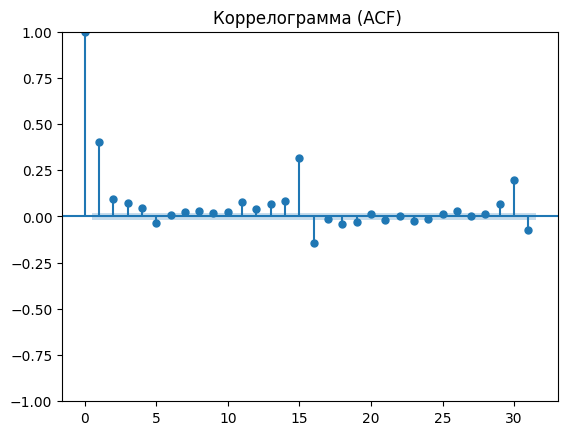

In [8]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf

# Пример данных (замените на свои)

# Построение коррелограммы

plot_pacf(df[df['company']=='SBER']['volume'], lags=31)  # lags — количество анализируемых лагов
plt.title("Коррелограмма (ACF) ")
plt.show()

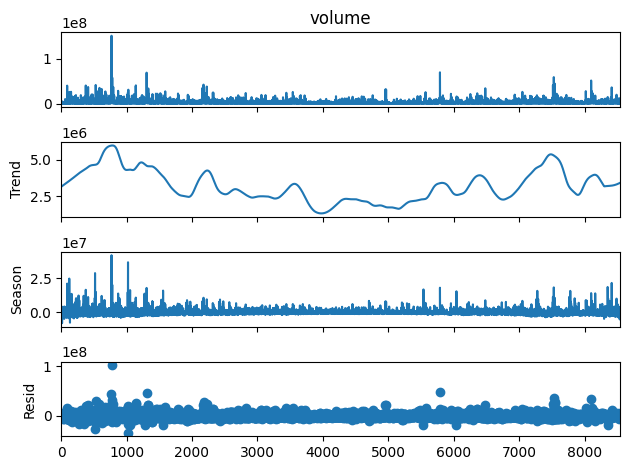

In [9]:
from statsmodels.tsa.seasonal import STL
import matplotlib.pyplot as plt

# Пример данных

# Декомпозиция STL
stl = STL(df[df['company']=='SBER']['volume'], period=252)  # period=12 для ежемесячных данных
result = stl.fit()
result.plot()
plt.show()

Index(['open', 'high', 'low', 'value', 'volume', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'mean_10', 'mean_50', 'volume_mean_10',
       'volume_mean_50', 'volume_mean_15', 'volume_mean_30', 'volume_var_10',
       'volume_var_50', 'volume_var_5', 'volume_var_15', 'value_mean_10',
       'value_mean_50', 'value_mean_15', 'value_mean_30', 'value_var_10',
       'value_var_50', 'value_var_5', 'value_var_15', 'close_mean_5',
       'close_var_5', 'close_mean_15', 'close_var_15', 'close_mean_7',
       'close_var_7', 'close_mean_30', 'close_var_30', 'open_mean_5',
       'open_var_10', 'volume_lag_1', 'value_lag_1', 'volume_lag_5',
       'value_lag_5', 'volume_lag_14', 'value_lag_14', 'volume_lag_15',
       'value_lag_15', 'volume_lag_31', 'value_lag_31', 'volume_lag_365',
       'value_lag_365', 'volume_lag_60', 'value_lag_60', 'sentiment_median',
       'sentiment_mean', 'sentiment_volatility', 'sentiment_count',
       'sentiment_skewness', 'sentiment_min', 'sentiment_max'

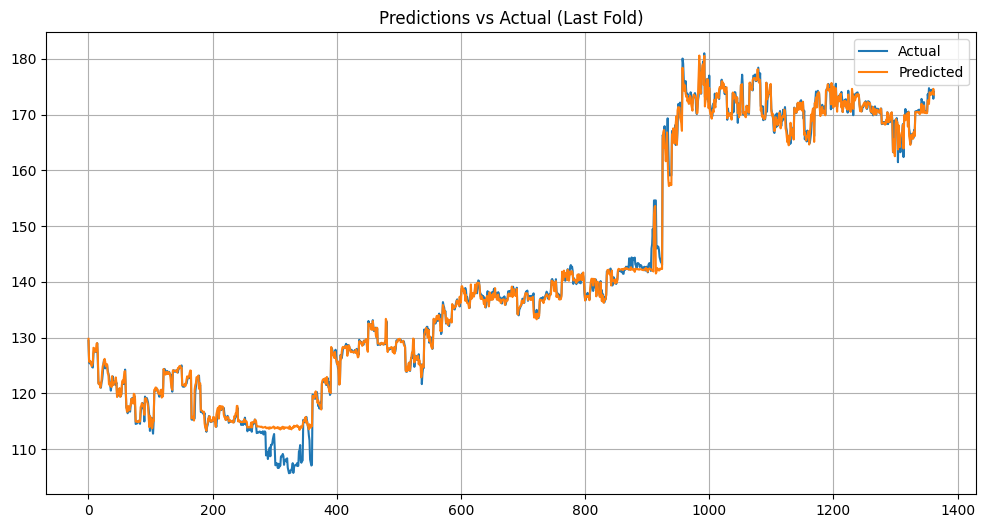

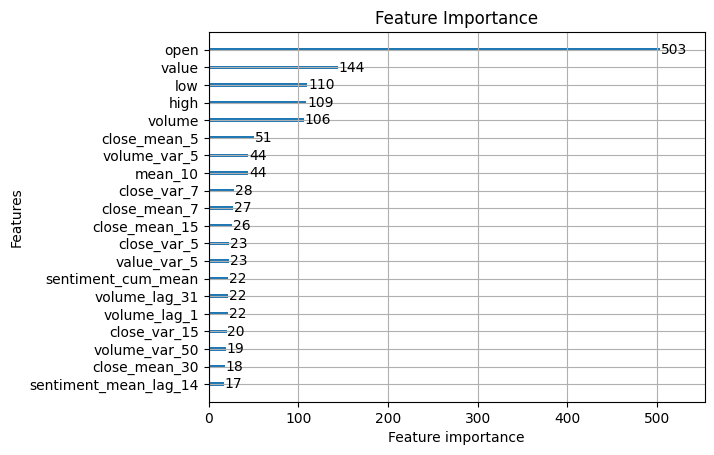

In [ ]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def train_and_evaluate_model(df):
    # Проверка данных
    try:
        df_processed = df.copy()
        # Удаляем ненужные колонки, если они существуют
        cols_to_drop = ['date', 'begin', 'end']
        cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
        df_processed.drop(columns=cols_to_drop, inplace=True)
        
        # Преобразование datetime-колонок
        datetime_cols = df_processed.select_dtypes(include=['datetime64', 'datetimetz']).columns
        for col in datetime_cols:
            df_processed[col] = df_processed[col].astype(np.int64) // 10**9
        
        # Проверяем наличие целевой переменной
        if 'target' not in df_processed.columns:
            raise ValueError("Целевая переменная 'target' отсутствует в данных")
            
        # Целевая переменная и признаки
        X = df_processed.drop('target', axis=1)
        y = df_processed['target']
        
        # Категориальные признаки
        non_numeric = X.select_dtypes(exclude=['number']).columns
        if len(non_numeric) > 0:
            X[non_numeric] = X[non_numeric].astype('category')

    except Exception as e:
        raise ValueError(f"Ошибка подготовки данных: {str(e)}")

    # Feature Selection
    # Базовая модель для оценки важности признаков
    base_model = lgb.LGBMRegressor(
        objective='regression',
        metric='huber',
        verbosity=-1,
        n_estimators=400,
        random_state=42
    )

    base_model.fit(X, y)
    print(X.columns)
    importance = base_model.feature_importances_
    selected_features = X.columns  # Отбираем признаки с ненулевой важностью
    
    if len(selected_features) == 0:
        raise ValueError("Ни один признак не был выбран. Проверьте данные.")
        
    X_selected = X[selected_features]

    # K-Fold Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)  # Для временных данных
    scores = {
        'MAE': [],
        'MSE': [],
        'RMSE': [],
        'R2': [],
        'MAPE': []
    }

    # Для визуализации сохраним данные последнего фолда
    last_fold_data = {}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_selected)):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = lgb.LGBMRegressor(
            objective='regression',
            metric='huber',
            verbosity=-1,
            random_state=42
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=10)
            ]
        )
        
        y_pred = model.predict(X_val)
        
        scores['MAE'].append(mean_absolute_error(y_val, y_pred))
        scores['MAPE'].append(mean_absolute_percentage_error(y_val, y_pred))
        scores['MSE'].append(mean_squared_error(y_val, y_pred))
        scores['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
        scores['R2'].append(r2_score(y_val, y_pred))
        
        # Сохраняем данные последнего фолда для визуализации
        if fold == tscv.n_splits - 1:
            last_fold_data = {
                'y_val': y_val,
                'y_pred': y_pred,
                'model': model
            }

    # Вывод средних метрик
    print("\nСредние метрики по фолдам:")
    print(f"MAE: {np.mean(scores['MAE'])} ± {np.std(scores['MAE'])}")
    print(f"MAPE: {np.mean(scores['MAPE'])} ± {np.std(scores['MAPE'])}")
    print(f"MSE: {np.mean(scores['MSE'])} ± {np.std(scores['MSE'])}")
    print(f"RMSE: {np.mean(scores['RMSE'])} ± {np.std(scores['RMSE'])}")
    print(f"R² Score: {np.mean(scores['R2'])} ± {np.std(scores['R2'])}")

    # Визуализация (последний фолд)
    if last_fold_data:
        plt.figure(figsize=(12, 6))
        plt.plot(last_fold_data['y_val'].values, label='Actual')
        plt.plot(last_fold_data['y_pred'], label='Predicted')
        plt.title('Predictions vs Actual (Last Fold)')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Важность признаков
        lgb.plot_importance(last_fold_data['model'], max_num_features=20)
        plt.title('Feature Importance')
        plt.show()
    
    return model, scores

model, scores = train_and_evaluate_model(test)

Добавим в test метрику сентимента

In [11]:
import json

with open('../data/model_data/model_data_cache.json', 'r') as f:
    sentiment_df = pd.DataFrame(json.load(f))
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_df['answer'] = sentiment_df['answer'].apply(int)
sentiment_df

,reasoning,answer,article_text,sphere,source,date
0,"Статья о финансовых результатах Rivian, америк...",15,Москва. 21 февраля. INTERFAX.RU - Американски...,Финансы,Интерфакс,2025-02-21
1,"Статья рассказывает о социальной акции ПАО ""Га...",0,Москва. 21 февраля. INTERFAX.RU - Село Майма ...,Финансы,Интерфакс,2025-02-21
2,"Статья сообщает о значительном убытке ПАО ""Рас...",-75,"Москва. 21 февраля. INTERFAX.RU - ПАО ""Распад...",Финансы,Интерфакс,2025-02-21
3,,0,Москва. 21 февраля. INTERFAX.RU - Российский ...,Энергетика,Интерфакс,2025-02-21
4,"Статья фокусируется на динамике рубля и юаня, ...",25,"Москва. 21 февраля. INTERFAX.RU - На ""Московс...",Энергетика,Интерфакс,2025-02-21
...,...,...,...,...,...,...
10708,Введение налогов на криптовалюты и регулирован...,-20,**Турция планирует ввести налоги на криптоакти...,Финансы/Энергетика,The Экономист,2024-05-12
10709,"Статья о проблемах в сельском хозяйстве, вызва...",25,**Российские фермеры и сельхозкомпании на гран...,Энергетика,The Экономист,2024-05-11
10710,Статья рассказывает о финансовой связи Романа ...,10,**Абрамович все еще влияет на футбол в условия...,Финансы,The Экономист,2024-05-11
10711,Статья описывает случай мошенничества с исполь...,-30,**Более 26 миллионов рублей пропало со счетов ...,Финансы,The Экономист,2024-05-10


In [12]:
test

,open,high,low,value,volume,begin,end,day_sin,day_cos,hour_sin,...,value_lag_14,volume_lag_15,value_lag_15,volume_lag_31,value_lag_31,volume_lag_365,value_lag_365,volume_lag_60,value_lag_60,target
8908,159.75,160.22,159.50,1.916315e+08,1198100,2023-02-06 14:00:00,2023-02-06 14:59:59,0.0,1.0,-5.000000e-01,...,2.683332e+09,1375540.0,2.161905e+08,680370.0,1.075537e+08,19650.0,3.202950e+06,626000.0,9.904674e+07,159.88
8909,159.88,160.19,159.61,1.715776e+08,1071970,2023-02-06 15:00:00,2023-02-06 15:59:59,0.0,1.0,-7.071068e-01,...,4.394738e+09,16760500.0,2.683332e+09,807210.0,1.277397e+08,1077940.0,1.759233e+08,1322310.0,2.092431e+08,160.20
8910,160.20,160.32,159.82,2.518204e+08,1573230,2023-02-06 16:00:00,2023-02-06 16:59:59,0.0,1.0,-8.660254e-01,...,1.110805e+09,27013140.0,4.394738e+09,625060.0,9.893620e+07,1516320.0,2.487698e+08,1338240.0,2.115839e+08,159.87
8911,159.86,160.32,159.81,4.082136e+08,2557490,2023-02-06 17:00:00,2023-02-06 17:59:59,0.0,1.0,-9.659258e-01,...,2.790517e+08,6856930.0,1.110805e+09,1420920.0,2.250017e+08,520110.0,8.524099e+07,1007460.0,1.593756e+08,159.59
8912,159.58,159.90,159.44,2.252173e+08,1412200,2023-02-06 18:00:00,2023-02-06 18:59:59,0.0,1.0,-1.000000e+00,...,1.575207e+08,1724180.0,2.790517e+08,632070.0,9.998954e+07,546890.0,8.949517e+07,815030.0,1.290488e+08,159.20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17081,174.51,174.75,173.75,1.054936e+09,6052380,2025-03-17 12:00:00,2025-03-17 12:59:59,0.0,1.0,1.224647e-16,...,1.420916e+07,191020.0,3.258430e+07,8857520.0,1.510127e+09,55770.0,9.604709e+06,2822530.0,4.707024e+08,174.21
17082,174.22,174.78,173.75,1.138134e+09,6535990,2025-03-17 13:00:00,2025-03-17 13:59:59,0.0,1.0,-2.588190e-01,...,2.380578e+07,83310.0,1.420916e+07,3637840.0,6.201000e+08,7496020.0,1.291505e+09,4905510.0,8.157585e+08,174.50
17083,174.50,174.60,173.42,2.926067e+09,16862050,2025-03-17 14:00:00,2025-03-17 14:59:59,0.0,1.0,-5.000000e-01,...,1.547456e+07,139660.0,2.380578e+07,1942830.0,3.312327e+08,5694700.0,9.790917e+08,10552430.0,1.745363e+09,172.85
17084,172.87,174.71,172.20,1.063962e+09,6128560,2025-03-17 15:00:00,2025-03-17 15:59:59,0.0,1.0,-7.071068e-01,...,1.623582e+07,90790.0,1.547456e+07,2072170.0,3.525862e+08,7474290.0,1.282536e+09,19059770.0,3.128753e+09,173.65


In [13]:
def add_sentiment_features(test_df, sentiment_df, sphere='Финансы', scale_factor=1000):
    """
    Добавляет расширенные sentiment-признаки к основному датафрейму
    
    Параметры:
    ----------
    test_df : pd.DataFrame
        Основной датафрейм с целевой переменной
    sentiment_df : pd.DataFrame
        Дадафрейм с sentiment-данными
    sphere : str, default='Финансы'
        Сфера для фильтрации sentiment
    scale_factor : int, default=1000
        Множитель для масштабирования sentiment
        
    Возвращает:
    -----------
    pd.DataFrame
        Обогащенный датафрейм с новыми признаками
    """
    # 1. Предобработка дат
    sentiment_df['date'] = pd.to_datetime(sentiment_df['date']).dt.date
    test_df['date'] = pd.to_datetime(test_df['begin']).dt.date
    
    # 2. Расширенная агрегация sentiment статистик
    sentiment_stats = (
        sentiment_df[sentiment_df['sphere'] == sphere]
        .groupby('date')['answer']
        .agg(['median', 'mean', 'std', 'count', 'skew', 'min', 'max'])
        .reset_index()
    )
    
    # 3. Добавление новых метрик на основе агрегатов
    sentiment_stats['daily_range'] = sentiment_stats['max'] - sentiment_stats['min']
    sentiment_stats['cv'] = sentiment_stats['std'] / sentiment_stats['mean']  # Коэффициент вариации
    sentiment_stats['extreme_positive'] = sentiment_stats['count'] * (sentiment_stats['mean'] > 0.8)
    sentiment_stats['extreme_negative'] = sentiment_stats['count'] * (sentiment_stats['mean'] < -0.8)
    
    # 4. Соединение с основным датафреймом
    test_df = test_df.merge(sentiment_stats, on='date', how='left')
    
    # 5. Масштабирование и переименование
    test_df = test_df.rename(columns={
        'median': 'sentiment_median',
        'mean': 'sentiment_mean',
        'std': 'sentiment_volatility',
        'count': 'sentiment_count',
        'skew': 'sentiment_skewness',
        'min': 'sentiment_min',
        'max': 'sentiment_max',
        'daily_range': 'sentiment_daily_range',
        'cv': 'sentiment_cv',
        'extreme_positive': 'sentiment_extreme_positive',
        'extreme_negative': 'sentiment_extreme_negative'
    })
    
    # Масштабирование sentiment
    scale_cols = ['sentiment_median', 'sentiment_mean', 'sentiment_volatility', 
                 'sentiment_daily_range', 'sentiment_cv']
    for col in scale_cols:
        test_df[col] = test_df[col] * scale_factor
    
    # 6. Добавление временных признаков
    test_df = test_df.sort_values('date')
    
    # Относительный импульс
    test_df['sentiment_relative_momentum_1'] = test_df['sentiment_mean'].pct_change(1)
    test_df['sentiment_relative_momentum_7'] = test_df['sentiment_mean'].pct_change(7)
    
    # Скользящие средние с разными окнами
    windows = [3, 5, 7, 14]
    for window in windows:
        test_df[f'sentiment_ma_{window}'] = test_df['sentiment_mean'].rolling(window).mean()
        test_df[f'sentiment_ema_{window}'] = test_df['sentiment_mean'].ewm(span=window).mean()
        
    # Кумулятивные метрики
    test_df['sentiment_cum_mean'] = test_df['sentiment_mean'].expanding().mean()
    test_df['sentiment_cum_std'] = test_df['sentiment_mean'].expanding().std()
    
    # Дневные и недельные тренды
    test_df['sentiment_trend_7'] = test_df['sentiment_mean'].rolling(7).apply(
        lambda x: np.polyfit(np.arange(len(x)), x, 1)[0], raw=True
    )
    
    # 7. Добавление сезонных признаков
    test_df['day_of_week'] = pd.to_datetime(test_df['begin']).dt.dayofweek
    test_df['month'] = pd.to_datetime(test_df['begin']).dt.month
    test_df['quarter'] = pd.to_datetime(test_df['begin']).dt.quarter
    
    # Среднее sentiment по дням недели
    day_of_week_means = test_df.groupby('day_of_week')['sentiment_mean'].transform('mean')
    test_df['sentiment_day_of_week_mean'] = day_of_week_means
    
    # 8. Добавление лаговых признаков
    lags = [1, 2, 3, 4, 5, 6, 7, 14]
    for lag in lags:
        test_df[f'sentiment_mean_lag_{lag}'] = test_df['sentiment_mean'].shift(lag)
        test_df[f'sentiment_volatility_lag_{lag}'] = test_df['sentiment_volatility'].shift(lag)
    
    # 9. Добавление волатильности волатильности
    test_df['volatility_of_volatility'] = test_df['sentiment_volatility'].rolling(7).std() * scale_factor
    
    # 10. Добавление индикаторов рыночного настроения
    test_df['bullish_indicator'] = (test_df['sentiment_mean'] > test_df['sentiment_mean'].quantile(0.75)).astype(int)
    test_df['bearish_indicator'] = (test_df['sentiment_mean'] < test_df['sentiment_mean'].quantile(0.25)).astype(int)
    
    # 11. Обработка пропусков
    sentiment_cols = [col for col in test_df.columns if 'sentiment' in col]
    test_df[sentiment_cols] = test_df[sentiment_cols].fillna(0)
    
    # 12. Удаление временных колонок
    if 'date' in test_df.columns:
        test_df = test_df.drop('date', axis=1)
    
    return test_df
test = add_sentiment_features(test, sentiment_df)

/tmp/ipykernel_1618404/3847886239.py:67: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['sentiment_relative_momentum_1'] = test_df['sentiment_mean'].pct_change(1)
/tmp/ipykernel_1618404/3847886239.py:68: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  test_df['sentiment_relative_momentum_7'] = test_df['sentiment_mean'].pct_change(7)


Index(['open', 'high', 'low', 'value', 'volume', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'mean_10', 'mean_50', 'volume_mean_10',
       'volume_mean_50', 'volume_mean_15', 'volume_mean_30', 'volume_var_10',
       'volume_var_50', 'volume_var_5', 'volume_var_15', 'value_mean_10',
       'value_mean_50', 'value_mean_15', 'value_mean_30', 'value_var_10',
       'value_var_50', 'value_var_5', 'value_var_15', 'close_mean_5',
       'close_var_5', 'close_mean_15', 'close_var_15', 'close_mean_7',
       'close_var_7', 'close_mean_30', 'close_var_30', 'open_mean_5',
       'open_var_10', 'volume_lag_1', 'value_lag_1', 'volume_lag_5',
       'value_lag_5', 'volume_lag_14', 'value_lag_14', 'volume_lag_15',
       'value_lag_15', 'volume_lag_31', 'value_lag_31', 'volume_lag_365',
       'value_lag_365', 'volume_lag_60', 'value_lag_60', 'sentiment_median',
       'sentiment_mean', 'sentiment_volatility', 'sentiment_count',
       'sentiment_skewness', 'sentiment_min', 'sentiment_max'

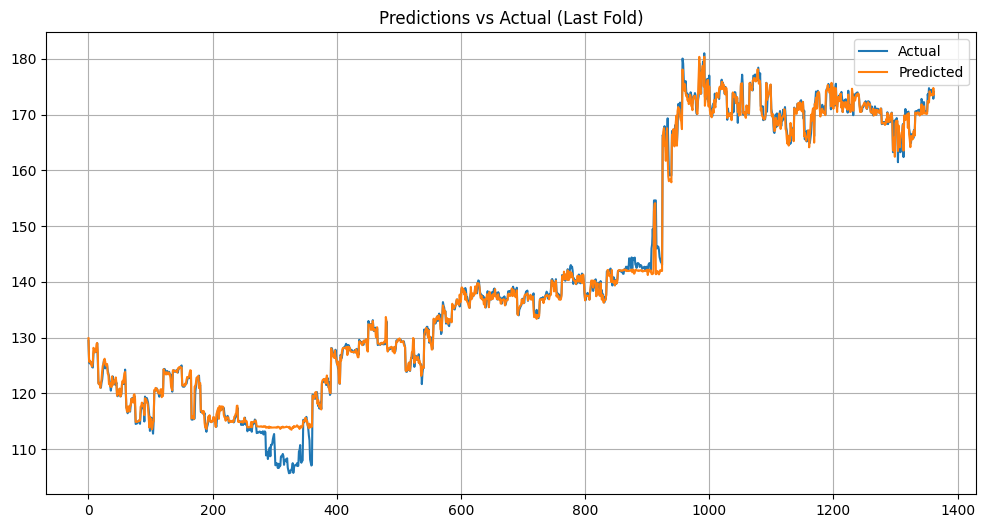

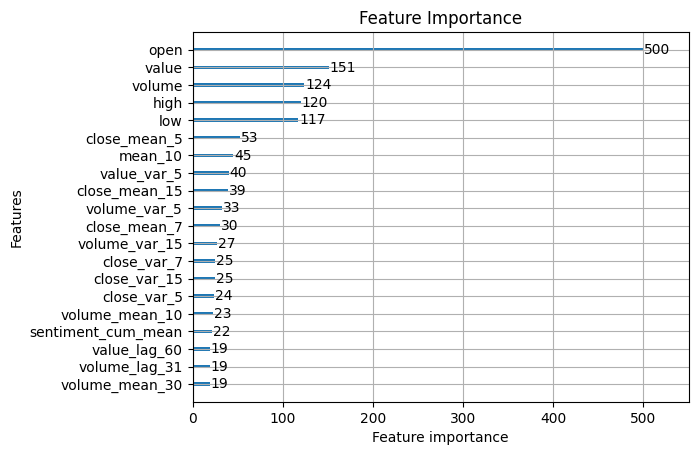

In [14]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def train_and_evaluate_model(df):
    # Проверка данных
    try:
        df_processed = df.copy()
        # Удаляем ненужные колонки, если они существуют
        cols_to_drop = ['date', 'begin', 'end']
        cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
        df_processed.drop(columns=cols_to_drop, inplace=True)
        
        # Преобразование datetime-колонок
        datetime_cols = df_processed.select_dtypes(include=['datetime64', 'datetimetz']).columns
        for col in datetime_cols:
            df_processed[col] = df_processed[col].astype(np.int64) // 10**9
        
        # Проверяем наличие целевой переменной
        if 'target' not in df_processed.columns:
            raise ValueError("Целевая переменная 'target' отсутствует в данных")
            
        # Целевая переменная и признаки
        X = df_processed.drop('target', axis=1)
        y = df_processed['target']
        
        # Категориальные признаки
        non_numeric = X.select_dtypes(exclude=['number']).columns
        if len(non_numeric) > 0:
            X[non_numeric] = X[non_numeric].astype('category')

    except Exception as e:
        raise ValueError(f"Ошибка подготовки данных: {str(e)}")

    # Feature Selection
    # Базовая модель для оценки важности признаков
    base_model = lgb.LGBMRegressor(
        objective='regression',
        metric='huber',
        verbosity=-1,
        n_estimators=400,
        random_state=42
    )

    base_model.fit(X, y)
    print(X.columns)
    importance = base_model.feature_importances_
    selected_features = X.columns  # Отбираем признаки с ненулевой важностью
    
    if len(selected_features) == 0:
        raise ValueError("Ни один признак не был выбран. Проверьте данные.")
        
    X_selected = X[selected_features]

    # K-Fold Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)  # Для временных данных
    scores = {
        'MAE': [],
        'MSE': [],
        'RMSE': [],
        'R2': [],
        'MAPE': []
    }

    # Для визуализации сохраним данные последнего фолда
    last_fold_data = {}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_selected)):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        model = lgb.LGBMRegressor(
            objective='regression',
            metric='huber',
            verbosity=-1,
            random_state=42
        )
        
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            callbacks=[
                lgb.early_stopping(stopping_rounds=10),
                lgb.log_evaluation(period=10)
            ]
        )
        
        y_pred = model.predict(X_val)
        
        scores['MAE'].append(mean_absolute_error(y_val, y_pred))
        scores['MAPE'].append(mean_absolute_percentage_error(y_val, y_pred))
        scores['MSE'].append(mean_squared_error(y_val, y_pred))
        scores['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
        scores['R2'].append(r2_score(y_val, y_pred))
        
        # Сохраняем данные последнего фолда для визуализации
        if fold == tscv.n_splits - 1:
            last_fold_data = {
                'y_val': y_val,
                'y_pred': y_pred,
                'model': model
            }

    # Вывод средних метрик
    print("\nСредние метрики по фолдам:")
    print(f"MAE: {np.mean(scores['MAE'])} ± {np.std(scores['MAE'])}")
    print(f"MAPE: {np.mean(scores['MAPE'])} ± {np.std(scores['MAPE'])}")
    print(f"MSE: {np.mean(scores['MSE'])} ± {np.std(scores['MSE'])}")
    print(f"RMSE: {np.mean(scores['RMSE'])} ± {np.std(scores['RMSE'])}")
    print(f"R² Score: {np.mean(scores['R2'])} ± {np.std(scores['R2'])}")

    # Визуализация (последний фолд)
    if last_fold_data:
        plt.figure(figsize=(12, 6))
        plt.plot(last_fold_data['y_val'].values, label='Actual')
        plt.plot(last_fold_data['y_pred'], label='Predicted')
        plt.title('Predictions vs Actual (Last Fold)')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Важность признаков
        lgb.plot_importance(last_fold_data['model'], max_num_features=20)
        plt.title('Feature Importance')
        plt.show()
    
    return model, scores

model, scores = train_and_evaluate_model(test)

Index(['open', 'high', 'low', 'value', 'volume', 'day_sin', 'day_cos',
       'hour_sin', 'hour_cos', 'mean_10', 'mean_50', 'volume_mean_10',
       'volume_mean_50', 'volume_mean_15', 'volume_mean_30', 'volume_var_10',
       'volume_var_50', 'volume_var_5', 'volume_var_15', 'value_mean_10',
       'value_mean_50', 'value_mean_15', 'value_mean_30', 'value_var_10',
       'value_var_50', 'value_var_5', 'value_var_15', 'close_mean_5',
       'close_var_5', 'close_mean_15', 'close_var_15', 'close_mean_7',
       'close_var_7', 'close_mean_30', 'close_var_30', 'open_mean_5',
       'open_var_10', 'volume_lag_1', 'value_lag_1', 'volume_lag_5',
       'value_lag_5', 'volume_lag_14', 'value_lag_14', 'volume_lag_15',
       'value_lag_15', 'volume_lag_31', 'value_lag_31', 'volume_lag_365',
       'value_lag_365', 'volume_lag_60', 'value_lag_60', 'sentiment_median',
       'sentiment_mean', 'sentiment_volatility', 'sentiment_count',
       'sentiment_skewness', 'sentiment_min', 'sentiment_max'

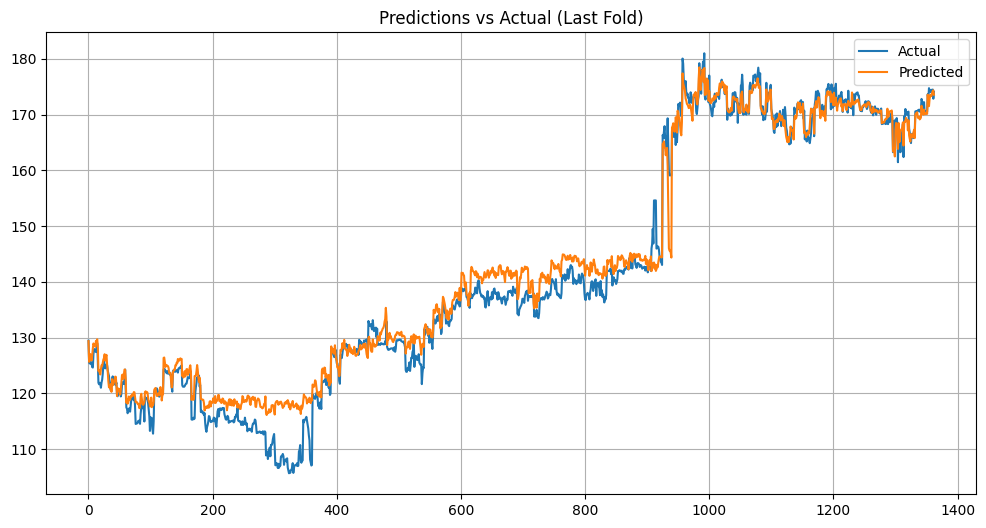

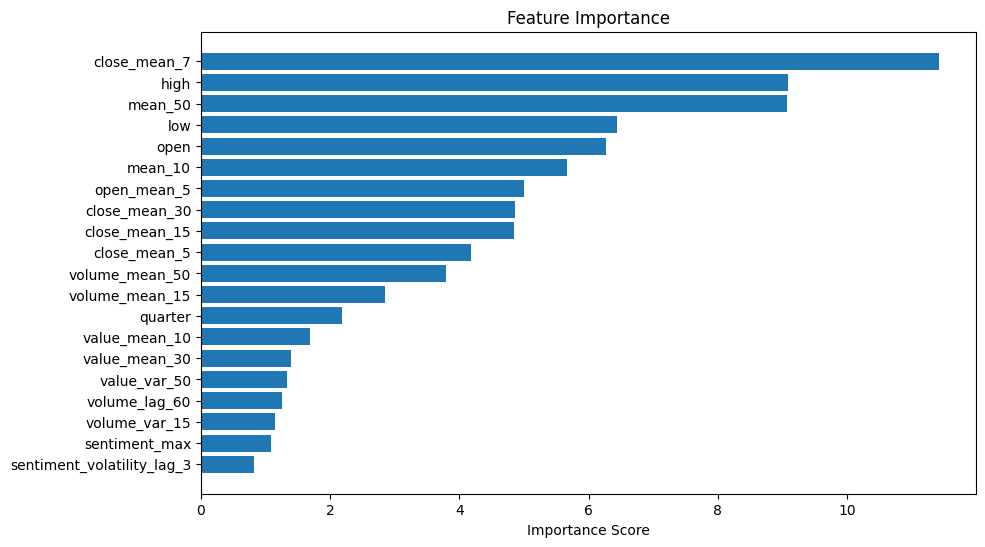

In [15]:
import pandas as pd
import numpy as np
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
import matplotlib.pyplot as plt

def train_and_evaluate_model_catboost(df):
    # Проверка данных
    try:
        df_processed = df.copy()
        # Удаляем ненужные колонки, если они существуют
        cols_to_drop = ['date', 'begin', 'end']
        cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
        df_processed.drop(columns=cols_to_drop, inplace=True)
        
        # Преобразование datetime-колонок
        datetime_cols = df_processed.select_dtypes(include=['datetime64', 'datetimetz']).columns
        for col in datetime_cols:
            df_processed[col] = df_processed[col].astype(np.int64) // 10**9
        
        # Проверяем наличие целевой переменной
        if 'target' not in df_processed.columns:
            raise ValueError("Целевая переменная 'target' отсутствует в данных")
            
        # Целевая переменная и признаки
        X = df_processed.drop('target', axis=1)
        y = df_processed['target']
        
        # Определяем категориальные признаки
        cat_features = X.select_dtypes(exclude=['number']).columns.tolist()

    except Exception as e:
        raise ValueError(f"Ошибка подготовки данных: {str(e)}")

    # Feature Selection
    # Базовая модель для оценки важности признаков
    base_model = CatBoostRegressor(
        loss_function='MAPE',
        verbose=False,
        iterations=400,
        random_state=42
    )

    base_model.fit(X, y, cat_features=cat_features, verbose=False)
    print(X.columns)
    importance = base_model.get_feature_importance()
    selected_features = X.columns  # Отбираем признаки с ненулевой важностью
    
    if len(selected_features) == 0:
        raise ValueError("Ни один признак не был выбран. Проверьте данные.")
        
    X_selected = X[selected_features]

    # K-Fold Cross-Validation
    tscv = TimeSeriesSplit(n_splits=5)  # Для временных данных
    scores = {
        'MAE': [],
        'MSE': [],
        'RMSE': [],
        'R2': [],
        'MAPE': []
    }

    # Для визуализации сохраним данные последнего фолда
    last_fold_data = {}

    for fold, (train_idx, test_idx) in enumerate(tscv.split(X_selected)):
        X_train, X_val = X_selected.iloc[train_idx], X_selected.iloc[test_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[test_idx]
        
        # Создаем Pool для CatBoost
        train_pool = Pool(X_train, y_train, cat_features=cat_features)
        val_pool = Pool(X_val, y_val, cat_features=cat_features)
        
        model = CatBoostRegressor(
            loss_function='MAPE',
            eval_metric='MAPE',
            random_state=42,
            verbose=0
        )
        
        model.fit(
            train_pool,
            eval_set=val_pool,
            use_best_model=True,
            plot=False
        )
        
        y_pred = model.predict(X_val)
        
        scores['MAE'].append(mean_absolute_error(y_val, y_pred))
        scores['MAPE'].append(mean_absolute_percentage_error(y_val, y_pred))
        scores['MSE'].append(mean_squared_error(y_val, y_pred))
        scores['RMSE'].append(np.sqrt(mean_squared_error(y_val, y_pred)))
        scores['R2'].append(r2_score(y_val, y_pred))
        
        # Сохраняем данные последнего фолда для визуализации
        if fold == tscv.n_splits - 1:
            last_fold_data = {
                'y_val': y_val,
                'y_pred': y_pred,
                'model': model
            }

    # Вывод средних метрик
    print("\nСредние метрики по фолдам:")
    print(f"MAE: {np.mean(scores['MAE'])} ± {np.std(scores['MAE'])}")
    print(f"MAPE: {np.mean(scores['MAPE'])} ± {np.std(scores['MAPE'])}")
    print(f"MSE: {np.mean(scores['MSE'])} ± {np.std(scores['MSE'])}")
    print(f"RMSE: {np.mean(scores['RMSE'])} ± {np.std(scores['RMSE'])}")
    print(f"R² Score: {np.mean(scores['R2'])} ± {np.std(scores['R2'])}")

    # Визуализация (последний фолд)
    if last_fold_data:
        plt.figure(figsize=(12, 6))
        plt.plot(last_fold_data['y_val'].values, label='Actual')
        plt.plot(last_fold_data['y_pred'], label='Predicted')
        plt.title('Predictions vs Actual (Last Fold)')
        plt.legend()
        plt.grid()
        plt.show()
        
        # Важность признаков
        feature_importance = last_fold_data['model'].get_feature_importance()
        sorted_idx = np.argsort(feature_importance)[-20:]  # топ-20 признаков
        plt.figure(figsize=(10, 6))
        plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
        plt.yticks(range(len(sorted_idx)), np.array(X_selected.columns)[sorted_idx])
        plt.title('Feature Importance')
        plt.xlabel('Importance Score')
        plt.show()
    
    return model, scores

# Пример вызова функции
model, scores = train_and_evaluate_model_catboost(test)